# Deutsch-Jozsa Algorithm

## Imports and requirements


To run this notebook it is requiered a python versin >= 3.10, personally, I am using python 3.11

In [ ]:
from platform import python_version
print(python_version())

In [ ]:
# Requieremts
%pip install os
%pip install qiskit
%pip install qiskit_ibm_runtime
%pip install numpy
%pip install matplot
%pip ipywidgets
%pip install python-dotenv


In [1]:
# Imports
from dotenv import load_dotenv
import os
import random
from qiskit import QuantumCircuit, generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import SparsePauliOp

from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler, EstimatorV2 as Estimator

from qiskit_aer import AerSimulator

In [ ]:
print(f"Qiskit version: {qiskit.__version__}")

Qiskit version: 2.1.1


You should have Qiskit version `>=2.0.0`. If you see a lower version, you need to restart your kernel and reinstall the library.

## IBM Quantum Runtime setup
Firstly we will setup the qiskit_ibm_runtime service so we can execute our circuit on a real hardware.
> ⚠️ **Note:**  
> It is highly recommended to check the [official IBM Quantum documentation](https://quantum.ibm.com/docs/).  
>
> In this notebook, we will use the **`.env` method**.  
> Create a `.env` file in the same folder as this notebook and write your **API key** and **CRN** there.  
>
> This approach keeps your credentials secure and out of the public repository.


In [3]:
# Load automatically the .env file from the root of the project 
load_dotenv(override=True)

# Check if the environment variables are set
print("🔑 Token (first 6 chars):", os.environ["IBM_QUANTUM_TOKEN"][:6], "...")

# Setup the IBM Quantum Runtime service
service = QiskitRuntimeService(
    channel=os.environ["IBM_QUANTUM_CHANNEL"],
    token=os.environ["IBM_QUANTUM_TOKEN"],
    instance=os.environ["IBM_QUANTUM_INSTANCE"]
)
# Check the available backends, if error then your .env is not correctly set
print("Available backends:")
for backend in service.backends():
    print(" -", backend.name)

🔑 Token (first 6 chars): b3fr8e ...
Available backends:
 - ibm_brisbane
 - ibm_torino


---

##  Environment Setup Summary

At this point, we have:
- Created a secure **`.env`** file containing our API key and CRN.  
- Configured the connection using **`QiskitRuntimeService`** without saving any credentials locally.  
- Verified that the environment variables are correctly loaded.

Now we are ready to start implementing the **Deutsch–Jozsa algorithm** using Qiskit.  
In the following sections, we will:
1. Review the theoretical foundations of the algorithm.  
2. Build the corresponding quantum circuits step by step.  
3. Test both **constant** and **balanced** functions on simulators and, optionally, on a real quantum backend.

---


# Deutsch-Jozsa-algorithm-implementation

## Introduction
The Deutsch–Jozsa algorithm distinguishes between constant and balanced functions exponentially faster than any classical deterministic algorithm. Even if it is not a usefull algorithm in a practical way, it is a simple example to show the quantum advantage.


## Algorithm description
Deutsch algorithm solves the parity problem for functions such us:

$$
\sum \;\; \longrightarrow \sum
$$
The outputs will be:

$$  0 \Leftrightarrow \; constant $$
$$ 1 \Leftrightarrow \; balanced$$

<br>
Deutsch-Jozsa algorithm is the extension of the Deustch algorithm for functions such us:

$$\sum^n \;\;\longrightarrow\;\; \sum \; , \quad n \geq 1 $$

To describe how this algorithm works , imagine this game: Alice, in LA sends a bit string to Bob, who is in NY. Bob calculates the image of some function $ f(x) $ that could work in two different ways. First  $f(x) = 0 \ $  or  $ f(x) = 1 $ , but never both, constant. Otherwise $ f(x) = 0 $ half of the times , $ f(x) = 1 $ the other half, balanced. The goal of Alice is knowing how this $ f(x) $ work, constant or balanced. 

If Bob agrees to use an unitary operator $ U_f $ then, Alice only needs a single query to know how the function $ f(x) $ behaves. On the other hand, the best classical method would require $ 2^{n-1} +1 $  queries.

## Implementation

We will follow the Qiskit workflow pattern: **Map → Optimize → Execute → Post-process**.  
This is the standard workflow used for implementing all quantum algorithms.

### Step 1: Map

Firstly we will setup our qubits. This means $|0\rangle^{\otimes n}$ for Alice and $ |1\rangle $ for Bob's qubit.



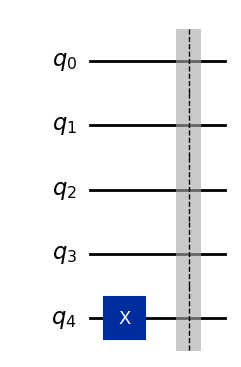

In [ ]:
# Define the initial state |ψ0⟩ = |0...01⟩
def psi_0(n:int) -> QuantumCircuit:
    qc = QuantumCircuit(n+1)
    qc.x(n)
    qc.barrier()
    return qc
# For example n = 4, 4 qubits for Alice and 1 for Bob
n = 4
qc = psi_0(n)
qc.draw('mpl')

As you can see. We initialize the circuit in the state $$ |\psi_0\rangle = |0\rangle^{\otimes (n-1)} |1\rangle $$ <br> 
To continue we need to create an entangled $|\psi_1\rangle =  H^{\otimes n}|\psi_0\rangle $ 
which is $$  H^{\otimes (n-1)}|0\rangle  \otimes H|1\rangle$$

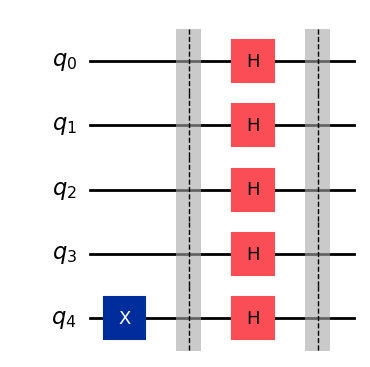

In [33]:
def psi_1(qc:QuantumCircuit,n:int):
    qc.h(range(n+1))
    qc.barrier()
    return qc
qc = psi_1(qc,n)
qc.draw('mpl')

Our quantum state $$ |\psi_1 \rangle = \displaystyle\sum_{x \in \{0,1\}^n}  \frac{|x\rangle}{\sqrt{2^n}} \otimes \frac{|0\rangle - |1\rangle}{\sqrt{2}} $$ <br>
For example for $ n = 2 $ $$  |\psi_1\rangle = \frac {|00\rangle +|01\rangle + |10\rangle + |11\rangle}{2} \otimes \frac{|0\rangle - |1\rangle}{\sqrt{2}}  $$ <br>


Now the query register is a superposition of all values. Then it is Bob's turn to evaluate $$ U_f : |Alice,Bob\rangle \rightarrow |Alice,Bob \oplus f(x)\rangle$$ <br>
$f(x) $ as we have seen, can output 2 values rather if it is balanced or constant. We will define one function for each behaviour. Let's check how $ U_f $ works:
$$
|\psi_2\rangle = \frac{1}{\sqrt{2^n}} \big[ U_f|x,0\rangle - U_f|x,1\rangle] = \frac{1}{\sqrt{2^n}} \big[ |x,0\oplus f(x)\rangle - |x,1\oplus f(x)\rangle] = \frac{1}{\sqrt{2^n}} \big[ |x,f(x)\rangle - |x,1\oplus f(x)\rangle]
$$ <br>
$$
|\psi_2 \rangle = \frac{1}{\sqrt{2^n}} \big[|x,f(x)]
$$


In [ ]:
# Define a seed for better reproduction
seed = 23
def constant(rand_n)-> int:
    
    if rand_n < 0.5:
        return 0
    else:
        return 1
def balanced() -> int:
    return
    
def uf(qc:QuantumCircuit,n)-> QuantumCircuit:
    rand_n = random.randint(0,1)
    if n in range()
    # balanced
    constant
    else
        #constant

    return qc

SyntaxError: invalid syntax (176860998.py, line 3)

$$ |\psi_2\rangle = \sum_x \frac{(-1)^{f(x)}|x\rangle}{\sqrt{2^n}} $$


## Referances 
Nielsen & Chuang, secciones 1.4.2–1.4.4.
ttps://quantum.cloud.ibm.com/learning/en/modules/computer-science/deutsch-jozsa


## To-do

AÑADIR REFERENCIA A PRIMERA PARTE "ALGORITHM DESCRIPTION" ALGO COMO  SEE ...